## 01 IO, Dimensional Reduction, and Clustering


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Author: [Antonia Mey -- @ppxasjsm](https://github.com/ppxasjsm)

## Learning objectives:
- a
- b
- c

You will be using the following functions in pyemma:

- `pyemma.coordinates.featurizer()` to define a selection of features we want to extract,
- `pyemma.coordinates.load()` to load data into memory, and
- `pyemma.coordinates.source()` to create a streamed feature reader in case the data does not fit into memory.
- `pyemma.plots.plot_feature_histograms()` to show the distributions of all loaded features,
- `pyemma.plots.plot_density()` to visualize the sample density, and
- `pyemma.plots.plot_free_energy()` to visualize the free energy surface of two selected features.



**Reading time**:
~ x mins

**Jupyter cheat sheet**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

## Let's start with the necessary imports

In [ ]:
%pylab inline
import mdshare
import pyemma
# for visualization of molecular structures:
import nglview
import mdtraj
from threading import Timer
import seaborn as sbn
sbn.set_context("paper",font_scale=1.4)

## Loading a molecular trajectory in `*.xtc` format (alanine dipeptide)

To load molecular dynamics data from one of the standard file formats ( `*.xtc`),
we need not only the actual simulation data, but a topology file, too.

In [ ]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')
print(pdb)
print(files)

We can visualise the structure using BioSimSpace in the following way:

!!!!!include code to visulaise for biosimspace

## The featurizer

In PyEMMA, the `featurizer` is a central object that incorporates the system's topology.
We start by creating it using the topology file.
Features are now easily computed by adding the target feature.
If no feature is added, the featurizer will extract Cartesian coordinates.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)

Now we pass the featurizer to the load function to extract the Cartesian coordinates from the trajectory files into memory.
⚠️ For real world examples it is best to use the `source()` function,
because not all your simulation data may fit into your workstations memory. 

The warning about **plain coordinates** is triggered,
because these coordinates will include diffusion as a dynamical process,
which might not be what one is interested in.
If the molecule of interest has been aligned to a reference prior the analysis,
it is fine to use these coordinates, but we will see that there are better choices. 

In [ ]:
data = pyemma.coordinates.load(files, features=feat)
print('type of data:', type(data))
print('lengths: %d' %len(data))
print('shape of elements: ', data[0].shape)
print('n_atoms: %d' %feat.topology.n_atoms)

Next, we start adding features which we want to extract from the simulation data.
Here, we want to load the backbone torsions,
because these angles are known to describe all flexibility in the system.
Since this feature is two dimensional, it is also easier to visualize.
Please note that, in complex systems, it is not trivial to visualize plain input features.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)

⚠️ Please note that the trajectories have been aligned to a reference structure before.
Since in this case we loose track of the periodic box,
we have to switch off the `periodic` flag for the torsion angle computations.
By default PyEMMA assumes your simulation uses periodic boundary conditions.

We can always call the featurizer's `describe()` method to show which features are requested.
You might have noticed that you can combine arbitrary features by having multiple calls to `add_` methods of the featurizer.

In [ ]:
data = pyemma.coordinates.load(files, features=feat)

print('type of data:', type(data))
print('lengths:', len(data))
print('shape of elements:', data[0].shape)

After we have selected all desired features,
we can call the `load()` function to load all features into memory or,
alternatively, the `source()` function to create a streamed feature reader.
For now, we will use `load()`:

In [ ]:
print(feat.describe())

Apparently, we have loaded a list of three two-dimensional `numpy.ndarray` objects from our three trajectory files.
We can visualize these features using the aforementioned plotting functions,
but to do so we have to concatenate the three individual trajectories:

In [ ]:
data_concatenated = np.concatenate(data)
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat);

We now use PyEMMA's `plot_density()` and `plot_free_energy()` functions to create Ramachandran plots of our system:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
# the * operator used in a function call is used to unpack
# the iterable variable into its single elements. 
pyemma.plots.plot_density(*data_concatenated.T, ax=axes[0])
pyemma.plots.plot_free_energy(*data_concatenated.T, ax=axes[1], legacy=True)
for ax in axes.flat:
    ax.set_xlabel('$\Phi$')
    ax.set_aspect('equal')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()

⚠️ Please note that these functions visualise the density and free energy of the sampled data, not the equilibrium distribution of the underlying system. To account for non-equiblibrium data, you can supply frame-wise weights using the weights parameter, which will be covered later. 

However, you can clearly see different basins which will be used for the MSM construction later. 


Let us look at a different featurization example and load the positions of all heavy atoms instead.
We create a new featurizer object and use its `add_selection()` method to request the positions of a given selection of atoms.
For this selection, we can use the `select_Heavy()` method which returns the indices of all heavy atoms.

Again, we load the data into memory and show what we loaded using the `describe()` method:

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_selection(feat.select_Heavy())

data = pyemma.coordinates.load(files, features=feat)

feat.describe()

⚠️ Please note that PyEMMA has flattened the $x, y$ and $z$ coordinates into an array that will be used for further analysis.

We visualize the distributions of all loaded features:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(np.concatenate(data), feature_labels=feat, ax=ax)
fig.tight_layout()

### `load()` versus `source()`

Using `load()`, we put the full data into memory.
This is possible for all examples in this tutorial.

Many real world applications, though, require more memory than your workstation might provide.
For these cases, you should use the `source()` function:

In [ ]:
reader = pyemma.coordinates.source(files, features=feat)
print(reader)

This function creates a reader, wich allows to stream the underlying data in chunks instead of the full set.
Most of the functions in the `coordinates` sub-package accept data in memory as well as readers.
However, some plotting functions require the data to be in memory.
To load a (sub-sampled) subset into memory, we can use the `get_output()` method with a stride parameter:

In [ ]:
data_output = reader.get_output(stride=5)
len(data_output)
print('number of frames in first file: {}'.format(reader.trajectory_length(0)))
print('number of frames after striding: {}'.format(len(data_output[0])))

We now have loaded every fifth frame into memory.
Again, we can visualize the (concatenated) features with a feature histogram:

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(
    np.concatenate(data_output), feature_labels=feat, ax=ax)
fig.tight_layout()

## Exercises on what you have learned so far

The exercises are announced by the keyword **Exercise** and followed by an incomplete cell.
Missing parts are indicated by
```python
#FIXME
```

#### Exercise 1: Heavy atom distances

Please fix the following code block such that the distances between all heavy atoms are loaded and visualized.

**Hint**: try to use the auto-complete feature on the feat object to gain some insight.
Also take a look at the previous demonstrations.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(# FIXME)
feat. #FIXME

data = pyemma.coordinates.load(files, features=feat)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(
    np.concatenate(data), feature_labels=feat, ax=ax)
fig.tight_layout()

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Heavy())
feat.add_distances(pairs)

data = pyemma.coordinates.load(files, features=feat)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(
    np.concatenate(data), feature_labels=feat, ax=ax)

fig.tight_layout()

In [ ]:
#### Exercise 2: Write out heavy atom distances

Please fix the following code to write out heavy atom distances to file

**Hint**: try to use the auto-complete feature on the feat object to gain some insight.
Also take a look at the previous demonstrations.

In [ ]:
feat. #FIXME

#### Solution

In [ ]:
feat.save('test.dat')

#### Exercise 3: Torsion angles again...

Please fix the following code to compute the `sin` and `cos` of the backbone torsional angles, as well as plot these features?



In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat. #FIXME

print(feat.describe())

In [ ]:
data = pyemma.coordinates.#FIXME
data_concatenated = #FIXME
pyemma.plots.#FIXME
fig.tight_layout()

#### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(cossin=True, periodic=False)

print(feat.describe())

Finally, we visualize the (concatenated) features:

In [ ]:
data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)
fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

### Exercises: feature selection and visualization

#### Exercise 3

Complete the following code block to load/visualize the distances between all $\text{C}_\alpha$ carbon atoms.

**Hint**: You might find the `add_distances_ca()` method of the featurizer object helpful.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat. #FIXME

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_distances_ca(periodic=False)

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

#### Exercise 4

Complete the following code block to load/visualize the position of all backbone atoms.

**Hint**: You might find the `select_Backbone()` method of the featurizer object helpful.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat. #FIXME

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_selection(feat.select_Backbone())

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 12))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

#### Exercise 6

Complete the following code block to load/visualize the position of all $\text{C}_\alpha$ atoms.

**Hint**: You might find the `select_Ca()` method of the featurizer object helpful.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat. #FIXME

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_selection(feat.select_Ca())

data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ax=ax)
fig.tight_layout()

## Clustering and dimensionality reduction

Let's go back to the nice backbone torsion view and use these to cluster data. 

In [50]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)
print(feat.describe())

['PHI 0 ALA 2', 'PSI 0 ALA 2']


Given the low dimensionality of this data set,
we can directly attempt to discretize,
e.g., with $k$-means with $100$ centers and a stride of $5$ to reduce the computational effort.
In real world examples we also might encounter low dimensional feature spaces
which do not require further dimension reduction techniques to be clustered efficiently.

#### k-means

In [51]:
cluster_kmeans = pyemma.coordinates.cluster_kmeans(data, k=100, max_iter=50, stride=5)

... or with a regspace technique where all centers should have a minimal pairwise distance of $0.5$ units of length.

#### regular spacial

In [52]:
cluster_regspace = pyemma.coordinates.cluster_regspace(data, dmin=0.3)

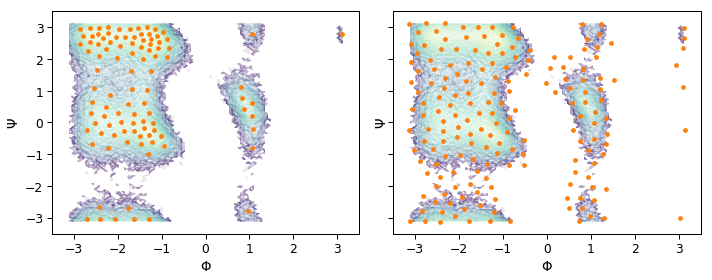

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, cls in zip(axes.flat, [cluster_kmeans, cluster_regspace]):
    pyemma.plots.plot_density(*data_concatenated.T, ax=ax, cbar=False, alpha=0.1, logscale=True)
    ax.scatter(*cls.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()

Have you noticed how the $k$-means centers follow the density of the data points while the regspace centers are spread uniformly over the whole area? 

If your are only interested in well sampled states, you should use a density based method to discretize.
If exploring new states is one of your objectives,
it might be of advantage to place states also in rarely observed regions.
The latter is especially useful in adaptive sampling approaches,
because in the initial phase you want to explore the phase space as much as possible.
The downside of placing states in areas of low density is that we will have poor statistics on these states. 

Another advantage of regular space clustering is that it is fast in comparison to $k$-means:
regspace clustering runs in linear time while $k$-means is superpolynomial in time.

⚠️ For large datasets we also offer a mini batch version of $k$-means which has the same semantics as the original method but trains the centers on subsets of your data.
This tutorial does not cover this case, but you should keep in mind that $k$-means requires your low dimensional space to fit into your main memory.


## Discrete trajectories
The main result of a discretization for Markov modeling, however,
is not the set of centers but the time series of discrete states.
These are accessible via the `dtrajs` attribute of any clustering object:

In [54]:
print(cluster_kmeans.dtrajs)
print(cluster_regspace.dtrajs)

[array([66, 10, 93, ..., 32, 15, 38], dtype=int32), array([18, 10, 93, ...,  6,  6, 41], dtype=int32), array([18, 74,  1, ..., 13, 35, 67], dtype=int32)]


[array([ 0,  1,  0, ...,  3, 13,  5], dtype=int32), array([ 0,  1,  0, ..., 35, 35, 35], dtype=int32), array([ 0, 11,  9, ..., 24, 24, 31], dtype=int32)]


For each trajectory passed to the clustering object, we get a corresponding discrete trajectory.

Please note that as an alternative to clustering algorithms such as $k$-means and regspace,
it is possible to manually assign the data to cluster centers using the `pyemma.coordinates.assign_to_centers()` function.

## Dimensionality reduction

Instead of discretizing the full (two-dimensional) space, we can attempt to find a one-dimensional subspace which
1. describes the slow dynamics of the data set equally well but
2. is easier to discretize.

One widespread method for dimension reduction is the principal component analysis (PCA) which finds a subspace with maximized variance:

In [55]:
pca = pyemma.coordinates.pca(data, dim=1)
pca_output = pca.get_output()
print(pca_output)

[array([[-1.4217829 ],
       [-1.6421818 ],
       [-1.4365987 ],
       ...,
       [-0.8850579 ],
       [-0.98456234],
       [-1.1861712 ]], dtype=float32), array([[-1.4552268 ],
       [-1.6580758 ],
       [-1.5196762 ],
       ...,
       [ 0.90252227],
       [ 0.9451862 ],
       [ 0.9375899 ]], dtype=float32), array([[-1.4610931 ],
       [-1.7745323 ],
       [-2.184506  ],
       ...,
       [ 1.2675216 ],
       [ 1.061178  ],
       [ 0.42867854]], dtype=float32)]


Another technique is the time-lagged independent component analysis (TICA) which finds a subspace with maximized autocorrelation <a id="ref-1" href="#cite-tica2">molgedey-94</a>, <a id="ref-2" href="#cite-tica">perez-hernandez-13</a>.
To compute the autocorrelation, we need a time shifted version of the data.
This time shift is specified by the `lag` argument.
For the current example, we choose a lag time of $1$ step.

In [56]:
tica = pyemma.coordinates.tica(data, dim=1, lag=1)
tica_output = tica.get_output()
print(tica_output)

[array([[-0.6081353 ],
       [-0.9466929 ],
       [-0.61435026],
       ...,
       [-0.67695755],
       [ 0.27954176],
       [ 0.24701042]], dtype=float32), array([[-0.55652475],
       [-0.95359075],
       [-0.6274867 ],
       ...,
       [ 0.39804858],
       [ 0.28693303],
       [ 0.4873239 ]], dtype=float32), array([[-0.5136929 ],
       [-0.2570551 ],
       [ 0.32987756],
       ...,
       [ 0.26248932],
       [ 0.26482752],
       [ 0.40485346]], dtype=float32)]


Instead of TICA, we can also employ the variational approach for Markov processes (VAMP) to obtain a coordinate transform <a id="ref-3" href="#cite-vamp-preprint">wu-17</a>.
In contrast to TICA, VAMP can be applied to non-equilibrium / non-reversible data.

In [57]:
vamp = pyemma.coordinates.vamp(data, dim=1, lag=1)
vamp_output = vamp.get_output()
print(vamp_output)

[array([[ 0.81786716],
       [ 1.2730067 ],
       [ 0.8262257 ],
       ...,
       [ 0.9102047 ],
       [-0.3754358 ],
       [-0.33164537]], dtype=float32), array([[ 0.74850583],
       [ 1.2822833 ],
       [ 0.8439092 ],
       ...,
       [-0.5353217 ],
       [-0.38597998],
       [-0.6553316 ]], dtype=float32), array([[ 0.69093555],
       [ 0.34607655],
       [-0.4427155 ],
       ...,
       [-0.3532259 ],
       [-0.35630363],
       [-0.54431885]], dtype=float32)]


⚠️ While there are many cases where PCA can find a suitable subspace,
there are also many cases where the PCA-based subspace neglects the slow dynamics.

In our example, the slow process is the jump between both wells along the $y$-axis while the $x$-axis contains only random noise. For all three methods, we show the distribution after projecting the full dynamics onto a one-dimensional subspace (left) and the direction of projection (right).

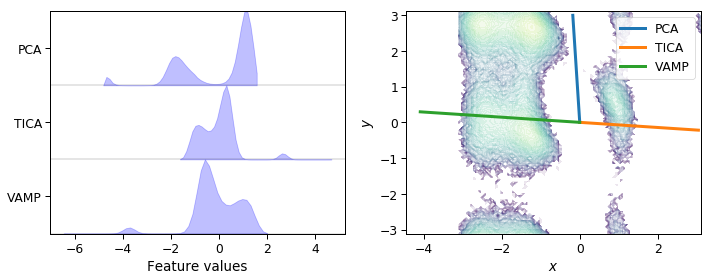

In [63]:
pca_concatenated = pca_output[0]
tica_concatenated = tica_output[0]
vamp_concatenated = vamp_output[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    np.concatenate([pca_concatenated, tica_concatenated, vamp_concatenated], axis=1),
    feature_labels=['PCA', 'TICA', 'VAMP'],
    ax=axes[0])
pyemma.plots.plot_density(*data_concatenated.T,ax=axes[1], cbar=False, alpha=0.1, logscale=True)
axes[1].plot(
    [0, 3 * pca.eigenvectors[0, 0]],
    [0, 3 * pca.eigenvectors[1, 0]],
    linewidth=3,
    label='PCA')
axes[1].plot(
    [0, 3 * tica.eigenvectors[0, 0]],
    [0, 3 * tica.eigenvectors[1, 0]],
    linewidth=3,
    label='TICA')
axes[1].plot(
    [0, 3 * vamp.singular_vectors_right[0, 0]],
    [0, 3 * vamp.singular_vectors_right[1, 0]],
    linewidth=3,
    label='VAMP')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
#axes[1].set_xlim(-4, 4)
#axes[1].set_ylim(-4, 4)
#axes[1].set_aspect('equal')
axes[1].legend()
fig.tight_layout()

We see that TICA and VAMP project along the $x$-axis and, thus, yield a subspace which clearly resolves both metastable states.
PCA on the other hand projects closely along the $y$-axis and does not resolve both metastable states.
This is a case in point where variance maximization does not find a subspace which resolves the relevant dynamics of the system.

This effect can also be seen when we plot the subspace time series:

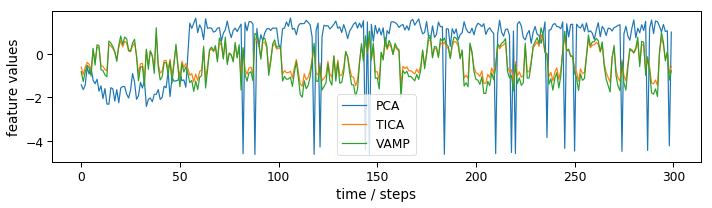

In [64]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(pca_concatenated[:300], label='PCA')
ax.plot(tica_concatenated[:300], label='TICA')
# note that for better comparability, we enforce the same direction as TICA
ax.plot(vamp_concatenated[:300] * -1, label='VAMP')
ax.set_xlabel('time / steps')
ax.set_ylabel('feature values')
ax.legend()
fig.tight_layout()

In case of TICA/VAMP and PCA, observe two different sets of metastable states. PCA resolves metastability along $\psi$ a and VAMP and TICA along $\phi$. In the analysis later on it will become clear that this is infact the coordinate for the slowest dynamics of the system. 

In many applications, however, we also need to understand what our coordinate transform means in physical terms.
This, in general, might be less obvious.
Hence, it might be instructive to inspect the correlations of features to the independent components:

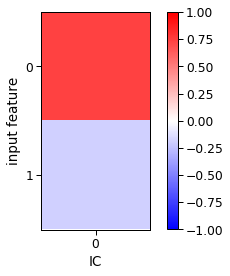

In [65]:
fig, ax = plt.subplots()
i = ax.imshow(tica.feature_TIC_correlation, cmap='bwr', vmin=-1, vmax=1)

ax.set_xticks([0])
ax.set_xlabel('IC')

ax.set_yticks([0, 1])
ax.set_ylabel('input feature')

fig.colorbar(i);

In this simple example, we clearly see a significant correlation between the $\phi$ component of the input data and the first independent component.

⚠️ In practice you almost never would like to use PCA as dimension reduction method in MSM building,
as it does not preserve kinetic variance. We are showing it here in these exercises to make this point clear.

### Streaming memory discretization
For real world case examples it is often not possible to load entire datasets into main memory. We can perform the whole discretization step without the need of having the dataset fit into memory. Keep in mind that this is not as efficient as loading into memory, because certain calculations (e.g. featurization), will have to be recomputed during iterations.

In [66]:
reader = pyemma.coordinates.source(files, top=pdb) # create reader
reader.featurizer.add_backbone_torsions(periodic=False) # add feature
tica = pyemma.coordinates.tica(reader) # perform tica on feature space
cluster = pyemma.coordinates.cluster_mini_batch_kmeans(tica, k=10, batch_size=0.1, max_iter=3) # cluster in tica space
# get result
dtrajs = cluster.dtrajs
print('discrete trajectories:', dtrajs)

15-05-19 17:32:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[46] INFO     Algorithm did not reach convergence criterion of 1e-05 in 3 iterations. Consider increasing max_iter.


discrete trajectories: [array([3, 3, 3, ..., 3, 6, 6], dtype=int32), array([3, 3, 3, ..., 9, 0, 9], dtype=int32), array([3, 3, 1, ..., 0, 0, 9], dtype=int32)]


We should mention that regular space clustering does not require to load the TICA output into memory, while $k$-means does. Use the minibatch version if your TICA output does not fit memory. Since the minibatch version takes more time to converge, it is therefore desirable to to shrink the TICA output to fit into memory. We split the pipeline for cluster estimation, and re-use the reader to for the assignment of the full dataset.

In [67]:
cluster = pyemma.coordinates.cluster_kmeans(tica, k=10, stride=3) # use only 1/3 of the input data to find centers

15-05-19 17:32:51 pyemma.coordinates.clustering.kmeans.KmeansClustering[47] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


Have you noticed how fast this converged compared to the minibatch version?
We can now just obtain the discrete trajectories by accessing the property on the cluster instance.
This will get all the TICA projected trajectories and assign them to the centers computed on the reduced data set.

In [68]:
dtrajs = cluster.dtrajs
print('Assignment:', dtrajs)
dtrajs_len = [len(d) for d in dtrajs]
for dtraj_len, input_len in zip(dtrajs_len, reader.trajectory_lengths()):
    print('Input length:', input_len, '\tdtraj length:', dtraj_len)

Assignment: [array([1, 1, 1, ..., 1, 8, 8], dtype=int32), array([1, 1, 1, ..., 0, 0, 0], dtype=int32), array([1, 1, 3, ..., 0, 0, 0], dtype=int32)]
Input length: 250000 	dtraj length: 250000
Input length: 250000 	dtraj length: 250000
Input length: 250000 	dtraj length: 250000


#### Exercise 1: data loading 

Load the heavy atoms' positions into memory.

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
feat. #FIXME
data = pyemma.coordinates.load(files, features=feat)

print('We have {} features.'.format(feat.dimension()))

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(np.concatenate(data), feature_labels=feat, ax=ax)
fig.tight_layout()

###### Solution

We have 30 features.


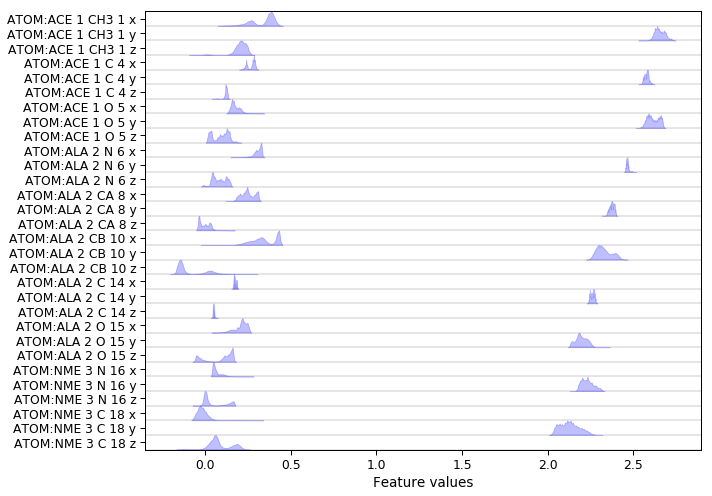

In [69]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_selection(feat.select_Heavy())
data = pyemma.coordinates.load(files, features=feat)

print('We have {} features.'.format(feat.dimension()))

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(np.concatenate(data), feature_labels=feat, ax=ax)
fig.tight_layout()

Discretizing a $30$-dimensional feature space is impractical.
Let's use PCA to find a low-dimensional projection and visualize the marginal distributions of all principal components (PCs) as well as the joint distributions for the first two PCs:

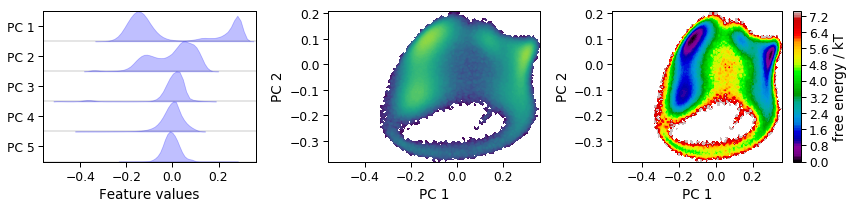

In [70]:
pca = pyemma.coordinates.pca(data)
pca_concatenated = np.concatenate(pca.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
pyemma.plots.plot_feature_histograms(
    pca_concatenated, ['PC {}'.format(i + 1) for i in range(pca.dimension())], ax=axes[0])
pyemma.plots.plot_density(*pca_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*pca_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
fig.tight_layout()

With the default parameters, PCA will return as many dimensions as necessary to explain $95\%$ of the variance;
in this case, we have found a five-dimensional subspace which does seem to resolve some metastability in the first three principal components.

#### Exercise 2: TICA visualization

Apply TICA and visualize the marginal distributions of all independent components (ICs) as well as the joint distributions of the first two ICs.

In [ ]:
tica =  #FIXME
tica_concatenated = np.concatenate(tica.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

###### Solution

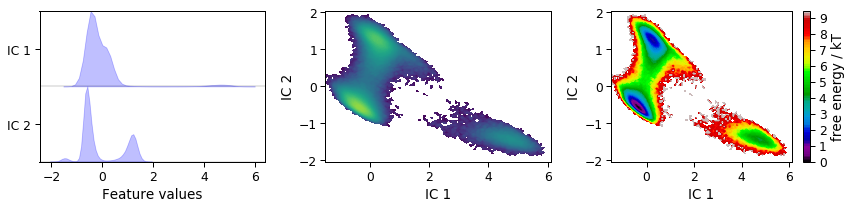

In [71]:
tica = pyemma.coordinates.tica(data)
tica_concatenated = np.concatenate(tica.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

TICA, by default, uses a lag time of $10$ steps, kinetic mapping and a kinetic variance cutoff of $95\%$ to determine the number of ICs.
We observe that this projection does resolve some metastability in both ICs.
Whether these projections are suitable for building Markov state models, though, remains to be seen in later tests
([Notebook 03 ➜ 📓](03-msm-estimation-and-validation.ipynb)).

As we discussed in the first example, the physical meaning of the TICA projection is not directly clear.
We can analyze the feature TIC correlation as we did above:

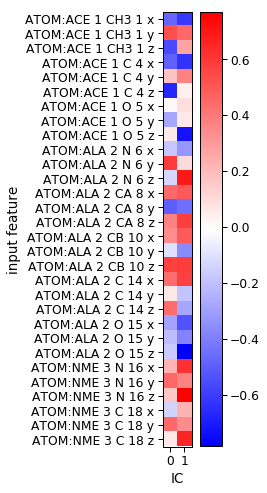

In [72]:
fig, ax = plt.subplots(figsize=(3, 8))
i = ax.imshow(tica.feature_TIC_correlation, cmap='bwr')

ax.set_xticks(range(tica.dimension()))
ax.set_xlabel('IC')

ax.set_yticks(range(feat.dimension()))
ax.set_yticklabels(feat.describe())
ax.set_ylabel('input feature')

fig.colorbar(i);

This is not helpful as it only shows that some of our $x, y, z$-coordinates correlate with the TICA components.
Since we rather expect the slow processes to happen in backbone torsion space, this comes to no surprise. 

To understand what the TICs really mean, let us do a more systematic approach and scan through some angular features.
We add some randomly chosen angles between heavy atoms and the backbone angles that we already know to be a good feature:

In [73]:
feat_test = pyemma.coordinates.featurizer(pdb)
feat_test.add_backbone_torsions(periodic=False)
feat_test.add_angles(feat_test.select_Heavy()[:-1].reshape(3, 3), periodic=False)
data_test = pyemma.coordinates.load(files, features=feat_test)
data_test_concatenated = np.concatenate(data_test)

For the sake of simplicity, we use scipy's implementation of Pearson's correlation coefficient which we compute between our test features and TICA projected $x, y, z$-coordinates:

In [74]:
from scipy.stats import pearsonr
test_feature_TIC_correlation = np.zeros((feat_test.dimension(), tica.dimension()))

for i in range(feat_test.dimension()):
    for j in range(tica.dimension()):
        test_feature_TIC_correlation[i, j] = pearsonr(
            data_test_concatenated[:, i],
            tica_concatenated[:, j])[0]

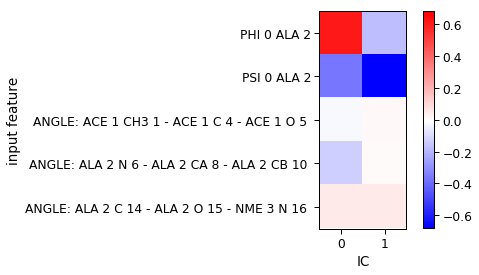

In [75]:
vm = abs(test_feature_TIC_correlation).max()

fig, ax = plt.subplots()
i = ax.imshow(test_feature_TIC_correlation, vmin=-vm, vmax=vm, cmap='bwr')

ax.set_xticks(range(tica.dimension()))
ax.set_xlabel('IC')

ax.set_yticks(range(feat_test.dimension()))
ax.set_yticklabels(feat_test.describe())
ax.set_ylabel('input feature')

fig.colorbar(i);

From this simple analysis, we find that features that correlated most with our TICA projection are indeed the backbone torsion angles used previously.
We might thus expect the dynamics in TICA space to be similar to the one in backbone torsion space.

⚠️ Please note that in general, we do not know which feature would be a good observable.
Thus, a realistic scenario might require a much broader scan of a large set of different features.

However, it should be mentioned that TICA projections do not necessarily have a simple physical interpretation.
The above analysis might very well end with feature TIC correlations that show no significant contributor and rather hint towards a complicated linear combination of input features.

As an alternative to understanding the projection in detail at this stage,
one might go one step further and extract representative structures,
e.g., from an MSM, as shown in [Notebook 05 📓](05-pcca-tpt.ipynb).

#### Exercise 3: PCA parameters

Perform PCA on the heavy atoms' positions data set with a target dimension of two;
then discretize the two-dimensional subspace using $k$-means with $100$ centers and a stride of $5$ to reduce the computational effort.

**Hint:** Look up the parameters of `pyemma.coordinates.pca()`, especially the `dim` parameter.

In [ ]:
pca =  # FIXME
pca_concatenated =  # FIXME

cluster = pyemma.coordinates.cluster_kmeans(pca, k=100, max_iter=50, stride=5)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    pca_concatenated, ['PC {}'.format(i + 1) for i in range(pca.dimension())], ax=axes[0])
pyemma.plots.plot_density(*pca_concatenated.T, ax=axes[1], cbar=False, alpha=0.1, logscale=True)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
fig.tight_layout()

###### Solution

In [ ]:
pca = pyemma.coordinates.pca(data, dim=2)
pca_concatenated = np.concatenate(pca.get_output())

cluster = pyemma.coordinates.cluster_kmeans(pca, k=100, max_iter=50, stride=5)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    pca_concatenated, ['PC {}'.format(i + 1) for i in range(pca.dimension())], ax=axes[0])
pyemma.plots.plot_density(*pca_concatenated.T, ax=axes[1], cbar=False, alpha=0.1, logscale=True)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
fig.tight_layout()

#### Exercise 4: TICA parameters

Perform TICA at lag time $1$ step on the heavy atoms' positions data set with a target dimension of two;
then discretize the two-dimensional subspace using $k$-means with $100$ centers and a stride of $5$ to reduce the computational effort.

**Hint:** Look up the parameters of `pyemma.coordinates.tica()`, especially the `dim` and `lag` parameters.

In [ ]:
tica =  # FIXME
tica_concatenated =  # FIXME

cluster =  # FIXME

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1], cbar=False, alpha=0.1, logscale=True)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

###### Solution

In [ ]:
tica = pyemma.coordinates.tica(data, lag=1, dim=2)
tica_concatenated = np.concatenate(tica.get_output())

cluster = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50, stride=5)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1], cbar=False, alpha=0.1, logscale=True)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

Have you noticed the difference in the first two ICs for lag times $10$ steps vs. $1$ step (e.g., result of exercises $2$ and $3$)?

## Case 3: another molecular dynamics data set (pentapeptide)

Before we start to load and discretize the pentapeptide data set,
let us discuss what the difficulties with larger protein systems are.
The goal of this notebook is to find a state space discretization for MSM estimation.
This means that an algorithm such as $k$-means has to be able to find a meaningful state space partitioning.
In general, this works better in lower dimensional spaces because Euclidean distances become less meaningful with increasing dimensionality <a id="ref-4" href="#cite-aggarwal_surprising_2001">aggarwal-01</a>.
The modeler should be aware that a discretization of hundreds of dimensions will be computationally expensive and most likely yield unsatisfactory results. 

The first goal is thus to map the data to a reasonable number of dimensions, e.g.,
with a smart choice of features and/or by using TICA.
Large systems often require significant parts of the kinetic variance to be discarded in order to obtain a balance between capturing as much of the kinetic variance as possible and achieving a reasonable discretization.

Another point about discretization algorithms is that one should bear in mind the distribution of density.
The $k$-means algorithm tends to conserve density, i.e.,
data sets that incorporate regions of extremely high density as well as poorly sampled regions might be problematic, especially in high dimensions.
For those cases, a regular spatial clustering might be worth a try. 

More details on problematic data situations and how to cope with them are explained in [Notebook 08 📓](08-common-problems.ipynb).

Now, we fetch the pentapeptide data set, load several different input features into memory and perform a VAMP estimation/scoring of each.
Since we want to evaluate the VAMP score on a disjoint test set,
we split the available files into a train and test set.

In [ ]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(cossin=True, periodic=False)
feat.add_sidechain_torsions(which='all', cossin=True, periodic=False)

train_files = files[:-2]
test_file = files[-2]  # last trajectory is our test data set
assert set(train_files) & set(test_file) == set()  # ensure test and train sets do not overlap

data_torsions = pyemma.coordinates.load(train_files, features=feat)
data_torsions_test = pyemma.coordinates.load(test_file, features=feat)

feat.active_features = []
feat.add_distances_ca(periodic=False)

data_dists_ca = pyemma.coordinates.load(train_files, features=feat)
data_dists_ca_test = pyemma.coordinates.load(test_file, features=feat)

feat.active_features = []
pairs = feat.pairs(feat.select_Heavy())
feat.add_contacts(pairs, periodic=False)

data_contacts = pyemma.coordinates.load(train_files, features=feat)
data_contacts_test = pyemma.coordinates.load(test_file, features=feat)

In [ ]:
def plot_for_lag(ax, lag, dim=3):
    vamp_torsions = pyemma.coordinates.vamp(data_torsions, lag=lag, dim=dim)
    vamp_dist_ca = pyemma.coordinates.vamp(data_dists_ca, lag=lag, dim=dim)
    vamp_contacts = pyemma.coordinates.vamp(data_contacts, lag=lag, dim=dim)

    vamps = (vamp_torsions, vamp_dist_ca, vamp_contacts)
    test_data = (data_torsions_test, data_dists_ca_test, data_contacts_test)
    labels = ('torsions', 'CA distances', 'contacts')
    for i, (v, test_data) in enumerate(zip(vamps, test_data)):
        s = v.score(test_data=test_data)
        ax.bar(i, s)
    ax.set_title('VAMP2 @ lag = {} ps'.format(lag))
    ax.set_xticks(range(len(vamps)))
    ax.set_xticklabels(labels)
    fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
plot_for_lag(axes[0], 5)
plot_for_lag(axes[1], 10)
plot_for_lag(axes[2], 20)
plot_for_lag(axes[3], 50)

For the small lag time we see that there is a large gap between torsion angles on the one hand and CA distances and contacts on the other hand.
For increasing lag times this gap vanishes, but also the overall score is decreasing.
Because we have capped the maximum dimension or equivalently the score to contain only the three largest components of the underlying dynamical model,
we can expect only a maximum score of three.
As we increase the lag time, more of the fast kinetic processes have already decayed.
So these are not contributing to the score anymore. 

We have learned that backbone and sidechain torsions are better suited than the other features for modeling the kinetics,
so we will continue with this feature.

In [ ]:
data_concatenated = data_torsions + [data_torsions_test] # concatenate two lists
type(data_concatenated)

We now perform a principal component analysis (PCA) with default parameters and visualize the marginal distributions of all PCs and the joint distributions of the first two PCs.

In [ ]:
pca = pyemma.coordinates.pca(data_concatenated, dim=2)
pca_concatenated = np.concatenate(pca.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    pca_concatenated,
    ['PC {}'.format(i + 1) for i in range(pca.dimension())],
    ax=axes[0])
pyemma.plots.plot_density(*pca_concatenated[:, :2].T, ax=axes[1], cbar=False)
pyemma.plots.plot_free_energy(*pca_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
fig.tight_layout()

We have a look at some TICA projections estimated with the lag times given below and, for each lag time,
we visualize the marginal distributions of all ICs and the joint distributions of the first two ICs.
The actual dimension is determined by the default variance cutoff of $95\%$.
This could be customized either by adjusting the `var_cutoff` or by requesting a certain number of dimensions with the `dim` keyword argument of `tica()`.

In [ ]:
lags = [1, 2, 5, 10, 20, 50]

fig, axes = plt.subplots(6, 3, figsize=(10, 18))
for i, lag in enumerate(lags):
    tica = pyemma.coordinates.tica(data_concatenated, lag=lag)
    tica_concatenated = np.concatenate(tica.get_output())
    pyemma.plots.plot_feature_histograms(
        tica_concatenated,
        ['IC {}'.format(i + 1) for i in range(tica.dimension())],
        ax=axes[i, 0])
    axes[i, 0].set_title('lag time = {} steps'.format(lag))
    axes[i, 1].set_title(
        'Density, actual dimension = {}'.format(tica.dimension()))
    pyemma.plots.plot_density(
        *tica_concatenated[:, :2].T, ax=axes[i, 1], cbar=False)
    pyemma.plots.plot_free_energy(
        *tica_concatenated[:, :2].T, ax=axes[i, 2], legacy=False)
for ax in axes[:, 1:].flat:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
axes[0, 2].set_title('Pseudo free energy')
fig.tight_layout()

Have you noticed that increasing the lag time
1. leads to a rotation of the projection and
2. reduces the number of TICs to explain $95\%$ (default) of the kinetic variance?

Note that, while we can get lower and lower dimensional subspaces with increased lag times, we also loose information from the faster processes.

How to choose the optimal lag time for a TICA projection often is a hard problem and there are only heuristic approaches to it.
For example, you can search for the amount of dimensions where the variance cutoff does not change anymore.

#### Exercise 5: PCA

Perform PCA with target dimension $3$ on the current feature set and discretize the projected space using $k$-means with $100$ centers and a stride of $5$ to reduce the computational effort.

In [ ]:
pca =  # FIXME
pca_concatenated = np.concatenate(pca.get_output(stride=5))

cluster =  # FIXME

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    pca_concatenated, ['PC {}'.format(i + 1) for i in range(pca.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(
        *pca_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15, c='C1')
    ax.set_xlabel('PC {}'.format(i + 1))
    ax.set_ylabel('PC {}'.format(j + 1))
fig.tight_layout()

###### Solution

In [ ]:
pca = pyemma.coordinates.pca(data_concatenated, dim=3)
pca_concatenated = np.concatenate(pca.get_output(stride=5))

cluster = pyemma.coordinates.cluster_kmeans(pca, k=100, max_iter=50, stride=5)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    pca_concatenated, ['PC {}'.format(i + 1) for i in range(pca.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(*pca_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15, c='C1')
    ax.set_xlabel('PC {}'.format(i + 1))
    ax.set_ylabel('PC {}'.format(j + 1))
fig.tight_layout()

#### Exercise 6: TICA

Perform TICA with target dimension $3$ and lag time $20$ steps on the current feature set and discretize the projected space using $k$-means with $100$ centers and a stride of $5$ to reduce the computational effort.

In [ ]:
tica =  # FIXME
tica_concatenated =  # FIXME

cluster =  # FIXME

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(
        *tica_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15, c='C1')
    ax.set_xlabel('IC {}'.format(i + 1))
    ax.set_ylabel('IC {}'.format(j + 1))
fig.tight_layout()

###### Solution

In [ ]:
tica = pyemma.coordinates.tica(data_concatenated, dim=3)
tica_concatenated = np.concatenate(tica.get_output(stride=5))

cluster = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50, stride=5)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(
        *tica_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15, c='C1')
    ax.set_xlabel('IC {}'.format(i + 1))
    ax.set_ylabel('IC {}'.format(j + 1))
fig.tight_layout()

#### Exercise 7: VAMP

Perform VAMP with target dimension $3$ and lag time $20$ steps on the current feature set and discretize the projected space using $k$-means with $100$ centers and a stride of $5$ to reduce the computational effort.

In [ ]:
vamp =  # FIXME
vamp_concatenated =  # FIXME

cluster =  # FIXME

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(vamp.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(
        *vamp_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15, c='C1')
    ax.set_xlabel('IC {}'.format(i + 1))
    ax.set_ylabel('IC {}'.format(j + 1))
fig.tight_layout()

###### Solution

In [ ]:
vamp = pyemma.coordinates.vamp(data_concatenated, lag=20, dim=3)
vamp_concatenated = np.concatenate(vamp.get_output(stride=5))

cluster = pyemma.coordinates.cluster_kmeans(vamp, k=100, max_iter=50, stride=5)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(*vamp_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15, c='C1')
    ax.set_xlabel('IC {}'.format(i + 1))
    ax.set_ylabel('IC {}'.format(j + 1))
fig.tight_layout()

## Wrapping up

In this notebook, we have learned how to reduce the dimension of molecular simulation data and discretize the projected dynamics with PyEMMA.
In detail, we have used
- `pyemma.coordinates.pca()` to perform a principal components analysis,
- `pyemma.coordinates.tica()` to perform a time-lagged independent component analysis, and
- `pyemma.coordinates.vamp()` to analyze the quality of some feature spaces, perform dimension reduction, and
- `pyemma.coordinates.cluster_kmeans()` to perform a $k$-means clustering, and
- `pyemma.coordinates.cluster_regspace()` to perform a regspace clustering.

## References

<a id="cite-tica2"/><sup><a href=#ref-1>[^]</a></sup>Molgedey, L. and Schuster, H. G.. 1994. _Separation of a mixture of independent signals using time delayed correlations_. [URL](http://dx.doi.org/10.1103/PhysRevLett.72.3634)

<a id="cite-tica"/><sup><a href=#ref-2>[^]</a></sup>Guillermo Pérez-Hernández and Fabian Paul and Toni Giorgino and Gianni De Fabritiis and Frank Noé. 2013. _Identification of slow molecular order parameters for Markov model construction_. [URL](https://doi.org/10.1063/1.4811489)

<a id="cite-vamp-preprint"/><sup><a href=#ref-3>[^]</a></sup>Wu, H. and Noé, F.. 2017. _Variational approach for learning Markov processes from time series data_. [URL](https://arxiv.org/pdf/1707.04659.pdf)

<a id="cite-aggarwal_surprising_2001"/><sup><a href=#ref-4>[^]</a></sup>Aggarwal, Charu C. and Hinneburg, Alexander and Keim, Daniel A.. 2001. _On the Surprising Behavior of Distance Metrics in High Dimensional Space_.




#### Disclaimer: 
This tutorial has been adapted from pyemma tutorials 01 and 02 (https://github.com/markovmodel/pyemma_tutorials)


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Maintainers of the original notebooks [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)



## References

<a id="cite-vamp-preprint"/><sup><a href=#ref-1>[^]</a></sup>Wu, H. and Noé, F.. 2017. _Variational approach for learning Markov processes from time series data_. [URL](https://arxiv.org/pdf/1707.04659.pdf)

